In [16]:
# Cell 1: Imports and configuration
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models

plt.style.use('seaborn-v0_8')
sns.set_context('talk')

DATA_PATH = '../data/raw/XAU_15m_data.csv'  # update if your file path differs
DT_COL_CANDIDATES = ['datetime', 'time', 'timestamp', 'Date', 'date']
PRICE_COL_CANDIDATES = ['close', 'Close', 'PRICE', 'Price']

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


In [19]:
# Cell 2: Robust loader and column detection
def detect_columns(df):
    dt_col = next((c for c in DT_COL_CANDIDATES if c in df.columns), None)
    if dt_col is None:
        raise ValueError(f"No datetime column detected. Checked: {DT_COL_CANDIDATES}")

    price_col = next((c for c in PRICE_COL_CANDIDATES if c in df.columns), None)
    if price_col is None and 'close' in df.columns:
        price_col = 'close'
    if price_col is None:
        raise ValueError(f"No price column detected. Checked: {PRICE_COL_CANDIDATES}")
    return dt_col, price_col

raw = pd.read_csv(DATA_PATH, sep=";", low_memory=False)
dt_col, price_col = detect_columns(raw)

raw[dt_col] = pd.to_datetime(raw[dt_col], errors='coerce', utc=True)
df = raw.dropna(subset=[dt_col]).sort_values(dt_col).set_index(dt_col)

# Normalize column names
df.columns = [c.lower() for c in df.columns]
price_col = price_col.lower() if price_col.lower() in df.columns else ('close' if 'close' in df.columns else df.columns[0])

# Keep essentials and drop non-numeric
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=[price_col])

print("Data shape:", df.shape)
print("Head:\n", df.head(3))
print("----------------------------------------------")

# Cell 3: Feature engineering (log returns for classification)
# Target: direction of next return (up/down) for classification
df['ret'] = df[price_col].pct_change()
df['log_ret'] = np.log1p(df['ret'])
df = df.dropna(subset=['log_ret'])

# Binary label: 1 if next log_ret > 0 else 0
df['label'] = (df['log_ret'].shift(-1) > 0).astype(int)
df = df.dropna(subset=['label'])

print("Class balance:", df['label'].value_counts(normalize=True).round(3))


Data shape: (485968, 5)
Head:
                             open   high    low  close  volume
Date                                                         
2004-06-11 07:15:00+00:00  384.0  384.3  383.8  384.3      12
2004-06-11 07:30:00+00:00  383.8  384.3  383.6  383.8      12
2004-06-11 07:45:00+00:00  383.3  383.8  383.3  383.8      20
----------------------------------------------
Class balance: label
0    0.515
1    0.485
Name: proportion, dtype: float64


In [20]:
# Cell 4: Build supervised sequences for CNN
# Input: rolling window of past log returns; Output: next-step direction label
WINDOW = 128     # sequence length (~32 hours for 15-min bars)
HORIZON = 1      # predict next step
STRIDE = 1       # step by one bar

series = df['log_ret'].values
labels = df['label'].values

X, y = [], []
for i in range(0, len(series) - WINDOW - HORIZON + 1, STRIDE):
    X.append(series[i:i+WINDOW])
    y.append(labels[i+WINDOW+HORIZON-1])

X = np.array(X)[:, :, None]  # add channel dimension
y = np.array(y).astype(int)

print("X shape:", X.shape, "y shape:", y.shape)
print("Positive class proportion:", y.mean().round(3))


X shape: (485839, 128, 1) y shape: (485839,)
Positive class proportion: 0.485


In [21]:
# Cell 5: Train/validation split (time-respecting)
# We avoid random shuffling to respect temporal order
VAL_RATIO = 0.2
split_idx = int(len(X) * (1 - VAL_RATIO))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Class weights to address imbalance
classes = np.array([0, 1])
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {0: cw[0], 1: cw[1]}
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.9626478630446412), 1: np.float64(1.040367782863567)}


In [25]:
# Cell 6: Light data augmentation for robustness
# Augment sequences with small Gaussian noise and random scaling
def augment_batch(x_batch, p_noise=0.7, p_scale=0.5, noise_std=0.05, scale_low=0.9, scale_high=1.1):
    x_aug = x_batch.copy()
    rng = np.random.default_rng(SEED)
    # Gaussian noise
    mask_noise = rng.random(size=(x_aug.shape[0])) < p_noise
    x_aug[mask_noise] += rng.normal(0, noise_std, size=x_aug[mask_noise].shape)
    # Random scaling
    mask_scale = rng.random(size=(x_aug.shape[0])) < p_scale
    scales = rng.uniform(scale_low, scale_high, size=(mask_scale.sum(), 1, 1))
    x_aug[mask_scale] *= scales
    return x_aug

# tf.data pipeline for efficient training with on-the-fly augmentation
BATCH_SIZE = 256

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(BATCH_SIZE).map(lambda xb, yb: (tf.numpy_function(augment_batch, [xb], tf.float64), yb))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [7]:
# Cell 7: Build the CNN (two conv–pool blocks with “same” padding)
def build_cnn(input_len=WINDOW, n_channels=1):
    model = models.Sequential([
        layers.Input(shape=(input_len, n_channels)),
        layers.Conv1D(32, kernel_size=5, padding='same', activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')  # binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn(input_len=WINDOW, n_channels=1)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 128, 32)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 64, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 64, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 32, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,697 (553.50 KB)

 Trainable params: 141,697 (553.50 KB)

 Non-trainable params: 0 (0.00 B)

380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
              precision    recall  f1-score   support

           0     0.4969    0.8707    0.6327     48280
           1     0.5032    0.1293    0.2058     48888

    accuracy                         0.4977     97168
   macro avg     0.5001    0.5000    0.4192     97168
weighted avg     0.5001    0.4977    0.4179     97168



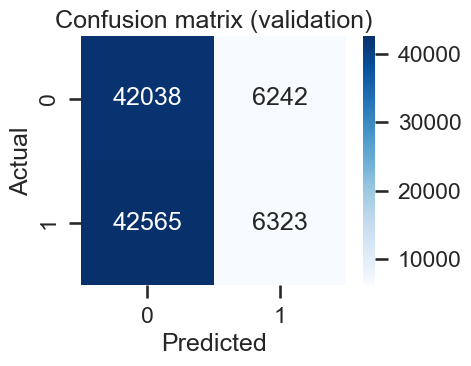

In [41]:
# Cell 10: Evaluation on validation set
val_probs = model.predict(X_val, batch_size=BATCH_SIZE).ravel()
val_pred = (val_probs >= 0.5).astype(int)

print(classification_report(y_val, val_pred, digits=4))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix (validation)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()


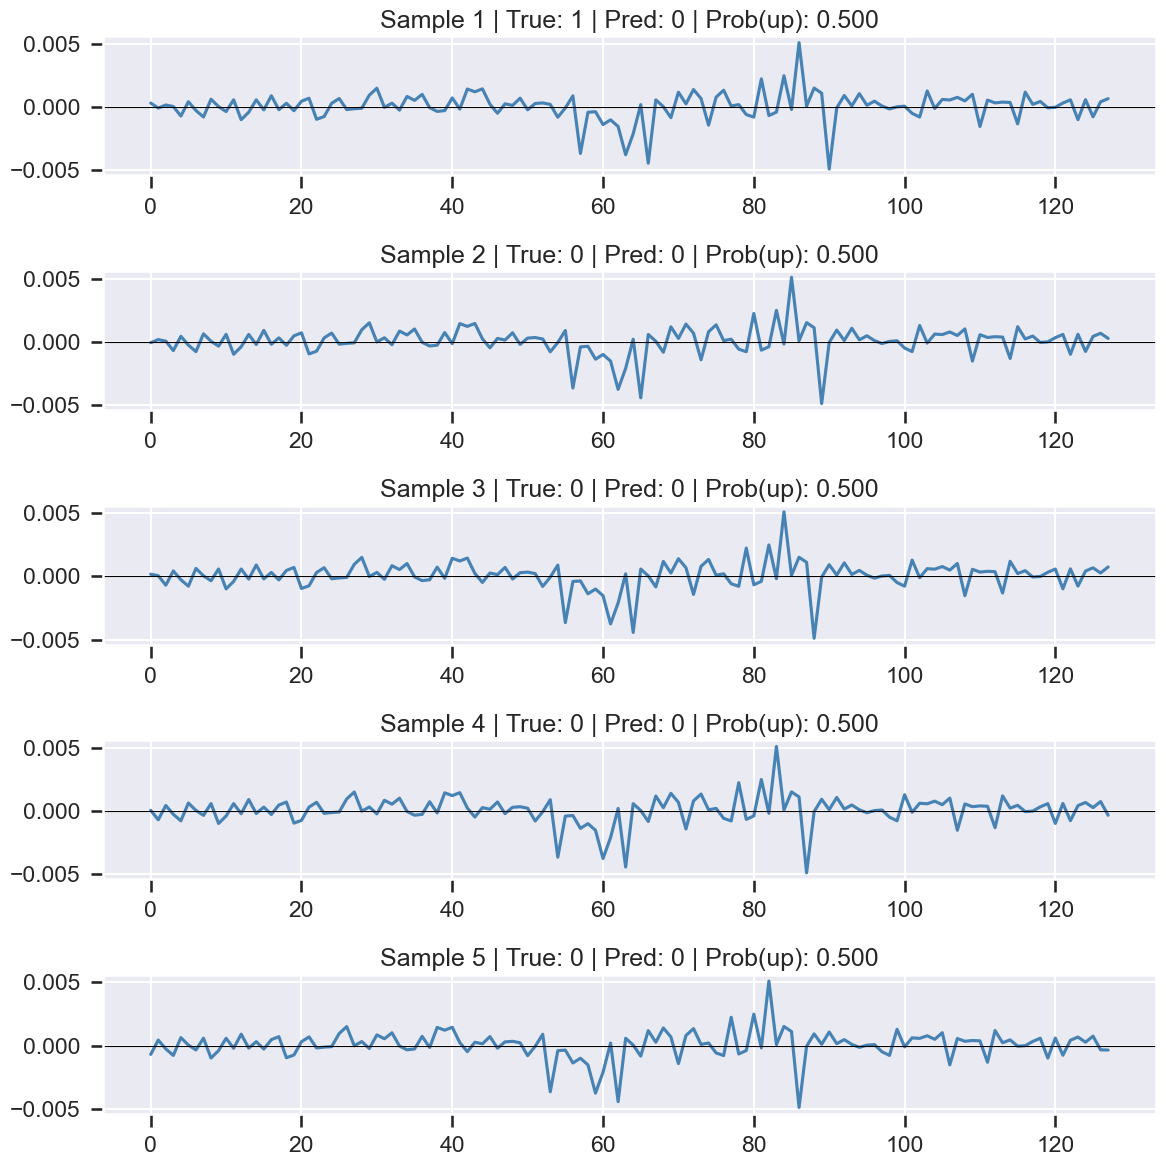

In [42]:
# Cell 11: Sample predictions visualization
# Show a few recent sequences and model probabilities
N_SAMPLES = 5
start_idx = max(0, len(X_val) - N_SAMPLES)
samples = X_val[start_idx:]
true = y_val[start_idx:]
probs = val_probs[start_idx:]
preds = val_pred[start_idx:]

fig, axes = plt.subplots(N_SAMPLES, 1, figsize=(12, 2*N_SAMPLES + 2), sharex=False)
for i in range(N_SAMPLES):
    axes[i].plot(samples[i].squeeze(), color='steelblue')
    axes[i].axhline(0, color='black', linewidth=0.8)
    axes[i].set_title(f"Sample {i+1} | True: {true[i]} | Pred: {preds[i]} | Prob(up): {probs[i]:.3f}")
plt.tight_layout()
plt.show()


In [43]:
# Cell 12: Save model and inference helper
MODEL_DIR = 'reports/models'
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, 'cnn_xau_direction.h5'))

def predict_next_direction(recent_log_returns, window=WINDOW):
    """
    recent_log_returns: 1D array-like of latest log returns (length >= window)
    Returns: probability of up (next-step positive return)
    """
    arr = np.array(recent_log_returns[-window:], dtype=float)[:, None][None, ...]
    prob = float(model.predict(arr).ravel()[0])
    return prob

print("Model saved. Inference helper ready.")


Model saved. Inference helper ready.


In [44]:
# Cell 13: Notes on why this matters (AI/ML relevance)
print("""
Why a CNN baseline on returns direction helps:
- Captures local temporal patterns and micro-seasonality that linear models miss.
- Binary classification gives an operational signal (up/down) with calibrated probability.
- Adam optimizer + two conv–pool blocks are strong defaults for noisy financial sequences.
- Learning curves (loss, accuracy) reveal over/underfitting quickly for iteration.
- Light augmentation (noise, scaling) adds robustness to small distribution shifts.
- This baseline complements classical ARIMA/ETS forecasts, forming an ensemble-ready pipeline.
""")



Why a CNN baseline on returns direction helps:
- Captures local temporal patterns and micro-seasonality that linear models miss.
- Binary classification gives an operational signal (up/down) with calibrated probability.
- Adam optimizer + two conv–pool blocks are strong defaults for noisy financial sequences.
- Learning curves (loss, accuracy) reveal over/underfitting quickly for iteration.
- Light augmentation (noise, scaling) adds robustness to small distribution shifts.
- This baseline complements classical ARIMA/ETS forecasts, forming an ensemble-ready pipeline.

